In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import background as bg

OpenCV and numpy, matplotlib for visualisation, and custom module doing work.

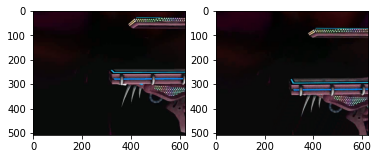

In [24]:
capture = cv.VideoCapture('videos/battlefield_camera.avi')
initial_skip = 4960
gap = 3
capture.set(cv.CAP_PROP_POS_FRAMES, initial_skip)
success, frame2 = capture.read()
capture.set(cv.CAP_PROP_POS_FRAMES, initial_skip + gap)
success, frame1 = capture.read()
H, W = frame1.shape[:2]

ax = plt.subplot(121)
ax.imshow(frame1)
ax = plt.subplot(122)
ax.imshow(frame2)
plt.show()

Grab sample frames from a video. Change initial_skip and/or gap to get different frames. Larger gap less likely to work well, but that's not such a bad thing for intended application where video frames are analyzed consecutively (ie gap = 1). Newer frame will find keypoint matches from older frame (hence the backwards order of frame1 and frame2)

In [25]:
kps1 = bg.custom_keypoints(frame1)
kps2 = bg.custom_keypoints(frame2)
len(kps1), len(kps2)

(44, 46)

Find keypoints in each frame with custom algorithm. It essentially finds long horizontal lines and then corners of those lines.

In [46]:
learner = bg.MyBackgroundLearner()
des1 = learner.binary_descriptors(kps1, frame1)
des2 = learner.binary_descriptors(kps2, frame2)

Find descriptors for keypoints custom BRIEF descriptor implementation.

In [47]:
def rnd_color():
    return [np.random.random() * 255 for _ in range(3)]

def slope(dy, dx):
    return dy / dx if not dx == 0 else 1000    # arbitrary big represent vertical slope

def hamming_dist(byte_str1, byte_str2):
    differences = 0
    for bit1, bit2 in zip(byte_str1, byte_str2):
        differences += bit1 ^ bit2  # python can only bitwise operate on ints from byte str,
    return differences              # not bits from bit string sadly

In [28]:
matches_result = []    # des2 matches for des1
for i in range(len(des1)):
    d1 = des1[i]
    dists = []
    for j in range(len(des2)):
        d2 = des2[j]
        dist = hamming_dist(d1, d2)
        k = 0
        while k < len(dists):
            if dist < dists[k][1]:
                break
            k += 1
        dists.insert(k, (j, dist))
    matches_result.append(dists)

Brute-force matching descriptors based on hamming distance, giving ordered results from des2 for each descriptor in des1.

In [29]:
kp_match_pairs = []
for i, kp in enumerate(kps1):
    ordered_matches = matches_result[i]
    best_match = ordered_matches[0]
    dist = best_match[1]
    index_of_match = best_match[0]
    kp_match = kps2[index_of_match]

    dist2 = ordered_matches[1][1]
    ratio = dist / dist2    # lowes ratio
    kp_match_pairs.append((kp, kp_match, ratio))
    
kp_match_pairs.sort(key=lambda x: x[2])
len(kp_match_pairs)

44

Match keypoints based on descriptor matches. Includes Lowe's ratio, measuring how unique the best match is compared to the second-best match. That ratio is not an optimal measure of matching success for this application because some corners look similar to other corners and shouldn't be penalized for that (eg left platform looks like right platform)

0.12 -14.0 40.0 -2.857142857142857
0.16 -13.0 40.0 -3.076923076923077
0.34 -14.0 42.0 -3.0
0.37 -14.0 43.0 -3.0714285714285716
0.43 60.0 43.0 0.7166666666666667
0.51 -17.0 44.0 -2.588235294117647
0.53 -16.0 44.0 -2.75
0.66 -10.0 42.0 -4.2
0.73 26.0 44.0 1.6923076923076923
0.73 14.0 43.0 3.0714285714285716
0.74 -8.0 43.0 -5.375
0.76 -20.0 38.0 -1.9
0.8 90.0 72.0 0.8
0.83 98.0 42.0 0.42857142857142855
0.85 20.0 53.0 2.65
0.88 0.0 34.0 1000
0.89 96.0 38.0 0.3958333333333333
0.89 4.0 35.0 8.75
0.9 10.0 17.0 1.7
0.91 -12.0 46.0 -3.8333333333333335
0.92 -54.0 24.0 -0.4444444444444444
0.92 -21.0 2.0 -0.09523809523809523
0.94 29.0 55.0 1.896551724137931
0.94 -64.0 26.0 -0.40625
0.99 56.0 75.0 1.3392857142857142
1.0 -67.0 49.0 -0.7313432835820896


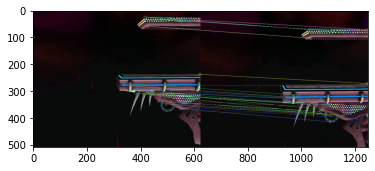

In [42]:
ratios = []
xdiffs = []
ydiffs = []
valid_pairs = []
combined = np.hstack((frame1, frame2))
for i, (kp1, kp2, ratio) in enumerate(kp_match_pairs):
    ratios.append(ratio)
    x0, y0 = kp1.pt
    x1, y1 = kp2.pt
    dy = (y1 - y0)
    dx = (x1 - x0)
    m = slope(dy, dx)

    if abs(dx) > 100 or abs(dy) > 100:
        continue
        
    valid_pairs.append((kp1, kp2))

    ydiffs.append(dy)
    xdiffs.append(dx)

    pt1 = (int(x0), int(y0))
    pt2 = (int(x1) + W, int(y1))
    color = rnd_color()
    combined = cv.circle(combined, pt1, 5, color)
    combined = cv.circle(combined, pt2, 5, color)
    combined = cv.line(combined, pt1, pt2, color, 1)
    print(round(ratio, 2), dx, dy, m)

plt.imshow(combined)
plt.show()

Visualize matches side-by-side. Output for each keypoint match is lowe's ratio, dx, dy, and slope. Discard matches exceeding a certain distance threshold because it's probably a bad match.

An extended slope threshold could be a nice, more accurate alternative.
```python
# Pseudocode for slope checking
for match in matches:
    new_slope = ( dy ) / ( dx + some_moderate_amount )    # adding distance (eg W) like the image does
    angle = inv_tangent(new_slope)
...
avg_angle = sum(angles) / len(angles)
if abs(angle - avg_angle) > threshold:
    discard match
```
Pros: more robust test than arbitrary dx or dy threshold, likely with more accurate results (eg if keypoints moved far but in the same direction)

Cons: need performance test, but inverse tangent might take a little too long and needs two loops to find average and then discard baddies afterwards. It also requires determining a suitable threshold, although that con also applies to previous test.

In [43]:
len(valid_pairs), len(kp_match_pairs)

(26, 44)

Valid matches (percieved) out of total matches

In [35]:
sum(xdiffs) / len(xdiffs), sum(ydiffs) / len(ydiffs), slope(sum(ydiffs), sum(xdiffs))

(6.115384615384615, 41.30769230769231, 6.754716981132075)

Avg dx, dy, slope

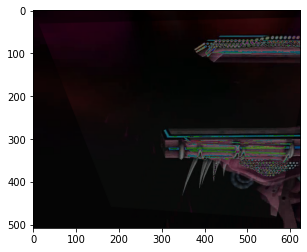

In [33]:
pts1 = np.array([kp1.pt for (kp1, kp2) in valid_pairs])
pts2 = np.array([kp2.pt for (kp1, kp2) in valid_pairs])

h, status = cv.findHomography(pts1, pts2)

warped = cv.warpPerspective(frame1, h, (W, H))

averaged = (warped + frame2) * 0.5
averaged = averaged.astype(np.uint8)

plt.imshow(averaged)
plt.show()

Find 2d homography transformation between good matches, then warp first frame with that transformation so it should look like second frame.

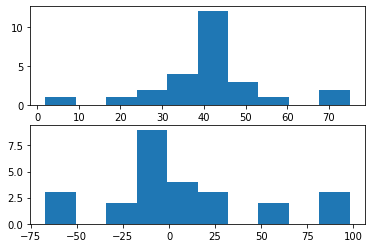

In [34]:
ax1 = plt.subplot(211)
plt.hist(ydiffs)
ax2 = plt.subplot(212)
plt.hist(xdiffs)
plt.show()

dx and dy for valid matches